In [1]:
import numpy as np
import pandas as pd
import json
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import sentence_transformers
import numpy as np
from nltk.tokenize import sent_tokenize
import matplotlib.pyplot as plt

tqdm.pandas()

/home/ttytu/anaconda3/envs/mmrec/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Open the JSON file
reviews_original = []
with open("./reviews_Sports.json", "r") as f:
    # Read the file line by line and load each line as a separate JSON object
    for line in f:
        reviews_original.append(json.loads(line))

# Define the keys to keep
keys_to_keep = ["reviewerID", "asin", "reviewText"]

# Create a new list of dictionaries with only the desired keys
reviews = [{key: review[key] for key in keys_to_keep} for review in reviews_original]

reviews = pd.DataFrame(reviews)
reviews = reviews.rename(columns={"reviewerID": "user_id"})

reviews.shape

(3268695, 3)

In [3]:
# Load data from CSV file
i_id_mapping = pd.read_csv("./i_id_mapping.csv", sep="\t")
u_id_mapping = pd.read_csv("./u_id_mapping.csv", sep="\t")

reviews_t = reviews.copy()

reviews_t = pd.merge(reviews_t, i_id_mapping, on="asin")
reviews_t = pd.merge(reviews_t, u_id_mapping, on="user_id")

reviews_t.drop(["asin", "user_id"], axis=1, inplace=True)

reviews_t.shape

(296337, 3)

In [4]:
reviews_t.to_csv('reviews-user-item_SPORTS.csv', index=False)

In [5]:
# Check if CUDA is available
if torch.cuda.is_available():
	device = torch.device("cuda")
else:
	device = torch.device("cpu")

# Load the pre-trained model
model = sentence_transformers.SentenceTransformer("sentence-transformers/sentence-t5-base")

# Move the model to the device
model.to(device)


# Define a function to get the document embeddings
def get_doc_embedding(text):
	if text == "":
		return np.zeros(768)

	# Tokenize the text into sentences
	sentences = sent_tokenize(text)

	# Get the embeddings for each sentence
	sentence_embeddings = model.encode(sentences)

	# Average the sentence embeddings to get the document embedding
	doc_embedding = np.mean(sentence_embeddings, axis=0)

	# print(text, doc_embedding.shape)
	return doc_embedding

In [6]:
reviews_t
reviews_tt = reviews_t.copy()

In [7]:
# Apply the function to each reviewText
reviews_t["embeddings"] = reviews_t["reviewText"].progress_apply(get_doc_embedding)
reviews_t.drop(["reviewText"], axis=1, inplace=True)

print(reviews_t["embeddings"][0])

100%|██████████| 296337/296337 [1:01:31<00:00, 80.27it/s]

[-4.09254730e-02 -2.03313492e-02  3.09268711e-03  5.32611050e-02
 -2.24381359e-03 -2.32633669e-02 -5.69686107e-02  2.33120285e-02
  6.98046060e-03 -2.00148318e-02  2.53291707e-02 -7.18332082e-02
  6.41928837e-02  6.83178520e-03  7.43168816e-02 -1.08000161e-02
  3.23695056e-02 -4.40188535e-02  3.23417969e-02  2.58593950e-02
  5.63803390e-02  3.93332914e-02 -5.42520434e-02 -1.61512941e-02
 -3.83649841e-02  2.60044895e-02  2.10922509e-02  5.91930817e-04
  2.41653826e-02 -7.65731744e-03  9.32505056e-02 -3.83456834e-02
 -4.01727743e-02  8.18571523e-02  1.47862062e-02 -2.85087223e-03
 -5.17562851e-02  1.20931931e-04 -1.21114738e-02  4.61291522e-02
 -3.12996618e-02 -5.56512550e-02 -2.31000502e-02  5.32274619e-02
 -4.54627723e-02  2.18317732e-02  1.91519707e-02  6.49743527e-02
 -9.74969659e-03 -5.16848564e-02 -5.28817065e-02 -3.75418067e-02
 -6.75860047e-02 -2.46183537e-02  6.21658703e-03  4.45205867e-02
  2.02839053e-03  5.17099462e-02  7.43514532e-03 -1.27989929e-02
 -8.82394537e-02  2.99363

In [8]:
reviews_t["embeddings"] = reviews_t["embeddings"].progress_apply(lambda x: x.tolist())
reviews_t.to_csv('reviews_feat_sentence-t5-base.csv', index=False)

In [9]:
reviews_t["embeddings"][0]

[-0.04092547297477722,
 -0.020331349223852158,
 0.0030926871113479137,
 0.053261104971170425,
 -0.002243813592940569,
 -0.023263366892933846,
 -0.05696861073374748,
 0.023312028497457504,
 0.006980460602790117,
 -0.02001483179628849,
 0.025329170748591423,
 -0.07183320820331573,
 0.06419288367033005,
 0.006831785198301077,
 0.07431688159704208,
 -0.010800016112625599,
 0.03236950561404228,
 -0.04401885345578194,
 0.03234179690480232,
 0.025859395042061806,
 0.056380338966846466,
 0.0393332913517952,
 -0.05425204336643219,
 -0.016151294112205505,
 -0.03836498409509659,
 0.02600448951125145,
 0.0210922509431839,
 0.0005919308168813586,
 0.024165382608771324,
 -0.007657317444682121,
 0.09325050562620163,
 -0.03834568336606026,
 -0.040172774344682693,
 0.08185715228319168,
 0.014786206185817719,
 -0.0028508722316473722,
 -0.05175628513097763,
 0.00012093193072360009,
 -0.012111473828554153,
 0.04612915217876434,
 -0.031299661844968796,
 -0.05565125495195389,
 -0.023100050166249275,
 0.0532

In [10]:
reviews_feat = pd.read_csv('reviews_feat_sentence-t5-base.csv')
print(reviews_feat.head())


   itemID  userID                                         embeddings
0       0       0  [-0.04092547297477722, -0.020331349223852158, ...
1    3327       0  [0.0019100414356216788, -0.03163861483335495, ...
2    3369       0  [-0.02461090125143528, -0.029628008604049683, ...
3    5458       0  [-0.021198062226176262, -0.018038298934698105,...
4   11981       0  [-0.02082611434161663, -0.04272026941180229, 0...


In [11]:
reviews_feat["embeddings"] = reviews_feat["embeddings"].progress_apply(lambda x: np.fromstring(x[1:-1], sep=', '))
reviews_feat["embeddings"][0]

100%|██████████| 296337/296337 [01:15<00:00, 3918.19it/s]


array([-4.09254730e-02, -2.03313492e-02,  3.09268711e-03,  5.32611050e-02,
       -2.24381359e-03, -2.32633669e-02, -5.69686107e-02,  2.33120285e-02,
        6.98046060e-03, -2.00148318e-02,  2.53291707e-02, -7.18332082e-02,
        6.41928837e-02,  6.83178520e-03,  7.43168816e-02, -1.08000161e-02,
        3.23695056e-02, -4.40188535e-02,  3.23417969e-02,  2.58593950e-02,
        5.63803390e-02,  3.93332914e-02, -5.42520434e-02, -1.61512941e-02,
       -3.83649841e-02,  2.60044895e-02,  2.10922509e-02,  5.91930817e-04,
        2.41653826e-02, -7.65731744e-03,  9.32505056e-02, -3.83456834e-02,
       -4.01727743e-02,  8.18571523e-02,  1.47862062e-02, -2.85087223e-03,
       -5.17562851e-02,  1.20931931e-04, -1.21114738e-02,  4.61291522e-02,
       -3.12996618e-02, -5.56512550e-02, -2.31000502e-02,  5.32274619e-02,
       -4.54627723e-02,  2.18317732e-02,  1.91519707e-02,  6.49743527e-02,
       -9.74969659e-03, -5.16848564e-02, -5.28817065e-02, -3.75418067e-02,
       -6.75860047e-02, -

In [12]:
reviews_feat = reviews_feat.sort_values(by=['userID', 'itemID'])
reviews_feat.head()

,itemID,userID,embeddings
0,0,0,"[-0.04092547297477722, -0.020331349223852158, ..."
1,3327,0,"[0.0019100414356216788, -0.03163861483335495, ..."
2,3369,0,"[-0.02461090125143528, -0.029628008604049683, ..."
3,5458,0,"[-0.021198062226176262, -0.018038298934698105,..."
4,11981,0,"[-0.02082611434161663, -0.04272026941180229, 0..."


In [13]:
reviews_emb = pd.DataFrame(reviews_feat["embeddings"].copy().tolist())
reviews_emb.shape

(296337, 768)

In [15]:
inter = pd.read_csv('sports.inter', sep='\t')
inter = inter.sort_values(by=['userID', 'itemID'])

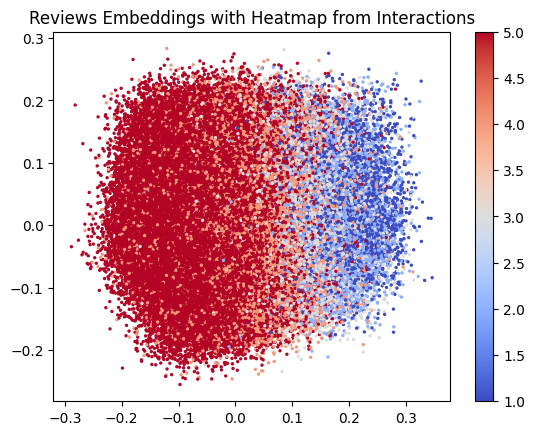

In [16]:
# Define the colors for the nodes
colors = inter["rating"]

from sklearn.decomposition import PCA

# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to the embeddings
pca.fit(reviews_emb)

# Transform the embeddings using the PCA model
pca_embeddings = pca.transform(reviews_emb)

# Plot the embeddings with the colors
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=colors, cmap='coolwarm', s=2)

# Add labels and title
plt.title('Reviews Embeddings with Heatmap from Interactions')

plt.colorbar()
plt.show()


In [17]:
reviews_feat_u = reviews_feat.copy().groupby('userID').mean().reset_index()
reviews_feat_i = reviews_feat.copy().groupby('itemID').mean().reset_index()

reviews_feat_u = reviews_feat_u.sort_values(by=['userID'])
reviews_feat_i = reviews_feat_i.sort_values(by=['itemID'])

In [18]:
reviews_u_emb = pd.DataFrame(reviews_feat_u["embeddings"].copy().tolist())
reviews_i_emb = pd.DataFrame(reviews_feat_i["embeddings"].copy().tolist())

In [19]:
ratings_u = inter.groupby('userID').mean().reset_index().sort_values(by=['userID'])
ratings_i = inter.groupby('itemID').mean().reset_index().sort_values(by=['itemID'])

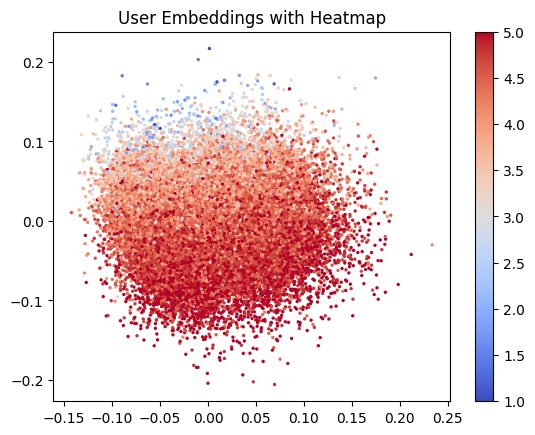

In [20]:
# Define the colors for the nodes
colors = ratings_u["rating"]

# Create a PCA object with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to the embeddings
pca.fit(reviews_u_emb)

# Transform the embeddings using the PCA model
pca_embeddings = pca.transform(reviews_u_emb)

# Plot the embeddings with the colors
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=colors, cmap='coolwarm', s=2)

# Add labels and title
plt.title('User Embeddings with Heatmap')

plt.colorbar()
plt.show()


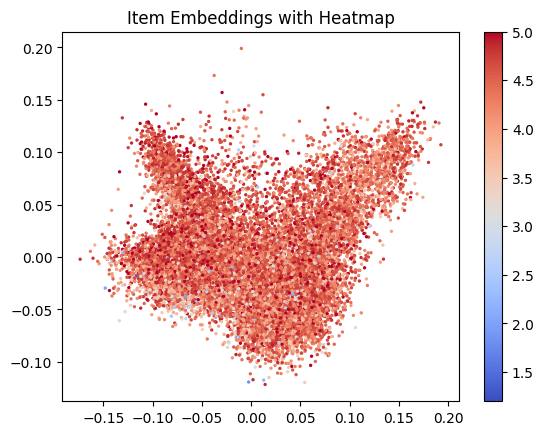

In [25]:
# Define the colors for the nodes
colors = ratings_i["rating"]

# Create a PCA object with 2 components
pca = PCA(n_components=4)

# Fit the PCA model to the embeddings
pca.fit(reviews_i_emb)

# Transform the embeddings using the PCA model
pca_embeddings = pca.transform(reviews_i_emb)

# Plot the embeddings with the colors
plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 2], c=colors, cmap='coolwarm', s=2)

# Add labels and title
plt.title('Item Embeddings with Heatmap')

plt.colorbar()
plt.show()


In [ ]:
reviews_feat_i.shape